In [378]:
## Подключаем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
from pandas_datareader import data as web
import datetime
from nsepy import get_history
from get_all_tickers import get_tickers as gt
from get_all_tickers.get_tickers import Region
from nsepython import *
import logging
urllib3_logger = logging.getLogger('urllib3') # Обработчик сообщений, чтобы они не выводились при сборе данных о тикерах
urllib3_logger.setLevel(logging.CRITICAL)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [767]:
# Задаем Тикер. Здесь вручную.
list_of_tickers = 'TUR'
# Задаем диапазон дат в котором нужно собирать все данные по тикерам
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,5,31) # сегодняшняя дата, чтобы не менять вручную.
# Получаем данные из Yahoo. Именно этот способ позволяет получить данные с тикерами в столбцах.
prices = pdr.DataReader(list_of_tickers, 'yahoo', start, end)

In [768]:
prices = pd.DataFrame(prices)
prices.index = pd.to_datetime(prices.index)
prices.head(3)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,27.18,27.000000,27.110001,27.09,132900.0,26.819000
2020-01-02,27.73,27.209999,27.250000,27.65,846500.0,27.373396
2020-01-03,26.93,26.709999,26.889999,26.73,711400.0,26.462601


In [769]:
# Преобразуем дневную частоту в месячную
prices = prices.asfreq('BM')
prices = prices.dropna()
prices.head(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,27.180000,27.000000,27.110001,27.090000,132900.0,26.819000
2020-01-31,27.889999,27.620001,27.889999,27.750000,419600.0,27.472399
2020-02-28,23.760000,23.330000,23.670000,23.650000,957200.0,23.413412
2020-03-31,19.170000,18.600000,19.040001,18.790001,486100.0,18.602032


In [770]:
# Рассчитываем годовую доходность. Т.к. у нас всего 12 промежутков, мы используем цифру 12 для расчета процентного изменения
prices['yearly_returns'] = prices['Adj Close'].pct_change(12) #######
prices.head()

,High,Low,Open,Close,Volume,Adj Close,yearly_returns
Date,,,,,,,
2019-12-31,27.180000,27.000000,27.110001,27.090000,132900.0,26.819000,NaN
2020-01-31,27.889999,27.620001,27.889999,27.750000,419600.0,27.472399,NaN
2020-02-28,23.760000,23.330000,23.670000,23.650000,957200.0,23.413412,NaN
2020-03-31,19.170000,18.600000,19.040001,18.790001,486100.0,18.602032,NaN
2020-04-30,20.309999,20.020000,20.200001,20.110001,151600.0,19.908827,NaN


In [771]:
# Рассчитаем доходность периода владения (1 мес)
prices['future_1_month_returns'] = prices['Adj Close'].pct_change(1).shift(-1)
prices = prices.dropna()
prices.head()

,High,Low,Open,Close,Volume,Adj Close,yearly_returns,future_1_month_returns
Date,,,,,,,,
2020-12-31,26.760000,26.450001,26.549999,26.500000,279000.0,26.500000,-0.011895,0.006038
2021-01-29,27.120001,26.660000,27.049999,26.660000,149700.0,26.660000,-0.029571,0.002251
2021-02-26,26.900000,26.370001,26.840000,26.719999,322200.0,26.719999,0.141226,-0.139596
2021-03-31,23.129999,22.790001,22.850000,22.990000,860300.0,22.990000,0.235886,0.013919


In [772]:
# Определим торговые сигналы
prices['positions'] = np.where(prices['yearly_returns'] > 0, 1, -1)
prices.tail(10)

,High,Low,Open,Close,Volume,Adj Close,yearly_returns,future_1_month_returns,positions
Date,,,,,,,,,
2020-12-31,26.760000,26.450001,26.549999,26.500000,279000.0,26.500000,-0.011895,0.006038,-1
2021-01-29,27.120001,26.660000,27.049999,26.660000,149700.0,26.660000,-0.029571,0.002251,-1
2021-02-26,26.900000,26.370001,26.840000,26.719999,322200.0,26.719999,0.141226,-0.139596,1
2021-03-31,23.129999,22.790001,22.850000,22.990000,860300.0,22.990000,0.235886,0.013919,1


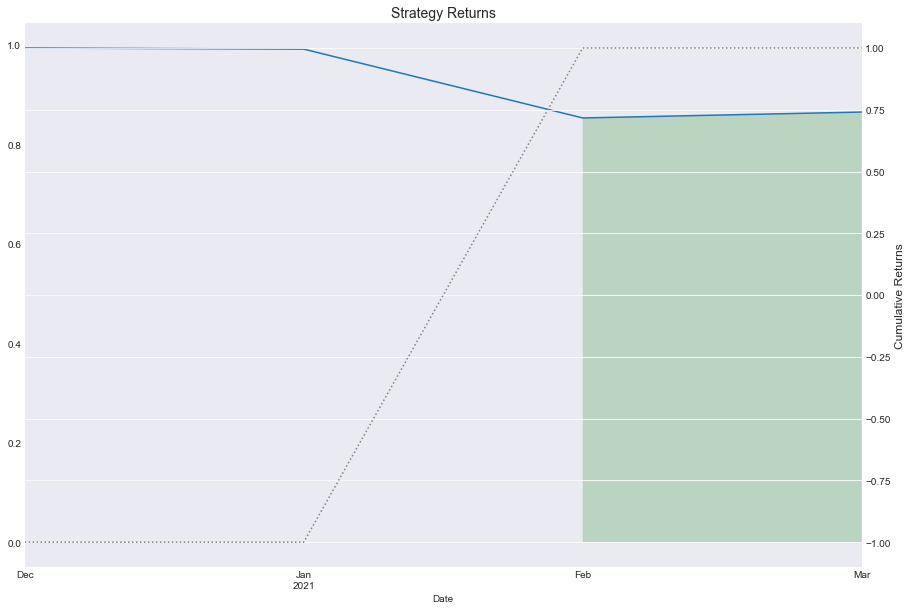

In [773]:
# Рассчитаем доходность стратегии
prices['strategy_return'] = prices['future_1_month_returns'] * prices['positions']

# Calculate the cumulative strategy returns
cumulative_strategy_returns = (prices['strategy_return'] +1).cumprod()

# Plot cumulative strategy returns
plt.style.use('seaborn-darkgrid')
cumulative_strategy_returns.plot(figsize=(10, 7))

plt.fill_between(prices.index, cumulative_strategy_returns, where=(prices.positions==1), facecolor='g', alpha=0.2)
prices['positions'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')

# Set title and labels for the plot
plt.title('Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.show()

In [774]:
# Рассчитаем кумулятивную доходность
total_returns = (cumulative_strategy_returns.iloc[-1]-1)*100
print('Полная доходность составила {:,.2f}%'.format(total_returns))
# Рассчитаем среднегодовую доходность
# Total number of months
total_months = len(cumulative_strategy_returns)
# Calculate compounded annual growth rate
cagr = (cumulative_strategy_returns.iloc[-1]**(12/total_months)-1)*100
print('   ')
print('CAGR стратегии составил {:,.2f}%'.format(cagr))
# Расчет среднегодовой волатильности
annualised_volatility = np.std(prices['strategy_return'])*(12**0.5)*100
print('   ')
print('Среднегодовая волатильность {:,.2f}%'.format(annualised_volatility))
# Коэффициент Шарпа
sharpe = (np.mean(prices['strategy_return']) /
          np.std(prices['strategy_return'])*(12**0.5))
print('   ')
print("Коэффициент Шарпа %.2f" % sharpe)

Полная доходность составила -13.48%
   
CAGR стратегии составил -35.24%
   
Среднегодовая волатильность 21.38%
   
Коэффициент Шарпа -1.88


In [775]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

drawdown = calc_drawdown(cumulative_strategy_returns)
max_dd = drawdown.min()*100
print('The maximum drawdown is {:,.2f}%'.format(max_dd))

The maximum drawdown is -14.67%


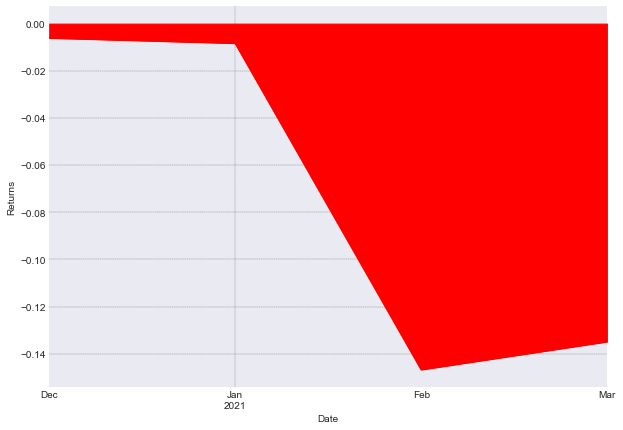

In [776]:
def plot_drawdown(drawdown):

    # Plot drawdown
    plt.figure(figsize=(10, 7))
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

plot_drawdown(drawdown)

In [777]:
# Задаем Тикер. Здесь вручную.
list_of_tickers = 'SPY'
# Задаем диапазон дат в котором нужно собирать все данные по тикерам
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2021,5,31) # сегодняшняя дата, чтобы не менять вручную.
# Получаем данные из Yahoo. Именно этот способ позволяет получить данные с тикерами в столбцах.
df = pdr.DataReader(list_of_tickers, 'yahoo', start, end)

In [778]:
from hurst import compute_Hc, random_walk
date_hurts = df.loc['2021-01-01':]['Close']
'Коэффициент Херста %.2f' % compute_Hc(date_hurts, kind='price')[0]

'Коэффициент Херста 0.57'